# Reproduction of `PhysRevLett.79.765`

```bibtex
@article{PhysRevLett.79.765,
  title     = {{Nature of Driving Force for Protein Folding: A Result From Analyzing the Statistical Potential}},
  author    = {Li, Hao and Tang, Chao and Wingreen, Ned S.},
  journal   = {Phys. Rev. Lett.},
  volume    = {79},
  issue     = {4},
  pages     = {765--768},
  numpages  = {0},
  year      = {1997},
  month     = {Jul},
  publisher = {American Physical Society},
  doi       = {10.1103/PhysRevLett.79.765},
  url       = {https://link.aps.org/doi/10.1103/PhysRevLett.79.765}
}
@article{10.1006/jmbi.1996.0114,
  title    = {{Residue – Residue Potentials with a Favorable Contact Pair Term and an Unfavorable High Packing Density Term, for Simulation and Threading}},
  journal  = {Journal of Molecular Biology},
  volume   = {256},
  number   = {3},
  pages    = {623-644},
  year     = {1996},
  issn     = {0022-2836},
  doi      = {https://doi.org/10.1006/jmbi.1996.0114},
  url      = {https://www.sciencedirect.com/science/article/pii/S002228369690114X},
  author   = {Sanzo Miyazawa and Robert L. Jernigan},
  keywords = {hydrophobicity, contact energy, residue packing energy, sequence threading, sequence sampling weights}
}
```

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

MJ-Matrix: adopt the upper half of Table 3 in ref[10.1006/jmbi.1996.0114].

In [2]:
mj_matrix_df = pd.read_csv('../data/mj_matrix.csv', index_col=0, skiprows=1)
mj_matrix = mj_matrix_df.to_numpy()

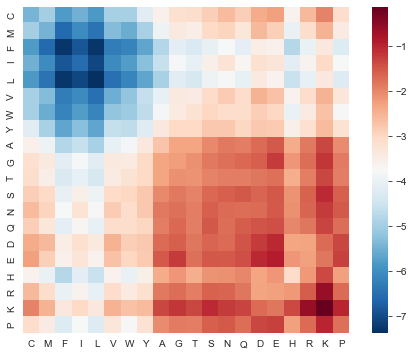

In [3]:
plt.figure(figsize=(8,6))
sns.heatmap(mj_matrix_df, square=True, cmap='RdBu_r')
plt.show()


$$
\begin{aligned}
M_{ij}-\langle M_{ij} \rangle=\sum_{\alpha=1}^{N}\lambda_{\alpha}V_{\alpha,i}V_{\alpha,j}, \quad \text{Eq. }(1) \\
\end{aligned}
$$

In [4]:
eig_vals, eig_vecs = np.linalg.eigh(mj_matrix-mj_matrix.mean())


> Such a subtraction procedure is necessary to remove a trivial source of a large eigenvalue. Any matrix with a nonzero mean $m_0$ can have one dominant eigen-value proportional to $Nm_0$ if the dimension $N$ of the matrix is large. Removing this trivial regularity enables us to clearly identify other intrinsic regularities which could be obscured in the spectrum of the unsubtracted matrix.

[-22.50373575  -1.55596307  -1.07471276  -0.60086612  -0.47326171
  -0.36414528  -0.2424168   -0.18057467  -0.09447336  -0.08476189
  -0.0284157    0.02600764   0.07073561   0.15347803   0.30414512
   0.32357128   0.39307364   0.7522797    2.38548112  18.73455497] 
min: 0.026, max: 2.385


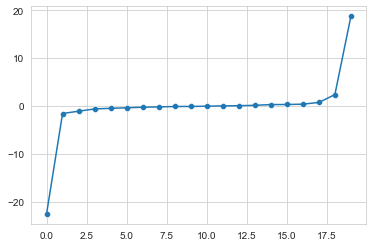

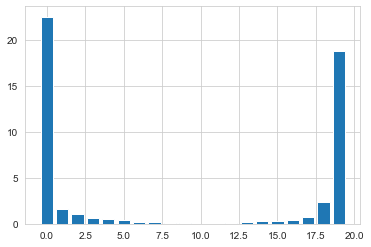

In [5]:
print(eig_vals, "\nmin: {:.3f}, max: {:.3f}".format(np.abs(eig_vals[1:-1]).min(), np.abs(eig_vals[1:-1]).max()))
sns.lineplot(data=eig_vals)
sns.scatterplot(data=eig_vals)
plt.show()
plt.bar(x=range(len(eig_vals)), height=np.abs(eig_vals))
plt.show()


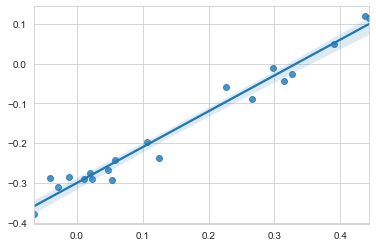

LinregressResult(slope=0.9006478176988847, intercept=-0.29987045793258704, rvalue=0.9860156612041119, pvalue=1.8466913761714847e-15, stderr=0.035879570728644644, intercept_stderr=0.008022915915276112)

In [6]:
sns.regplot(x=eig_vecs[:, 0], y=eig_vecs[:, -1])
plt.show()
lr = scipy.stats.linregress(eig_vecs[:, 0], eig_vecs[:, -1])
lr


$$
\begin{aligned}
\tilde{M}_{ij}&\approx\langle M_{ij} \rangle + \lambda_{1}V_{1,i}V_{1,j} + \lambda_{2}V_{2,i}V_{2,j} \\
V_{2,i}&\approx\beta+\gamma V_{1,i}, \; (\beta=-0.30,\;\gamma=0.90) \\
\\
\Rightarrow \tilde{M}_{ij}&\approx C_{0} + C_{1}(q_{i}+q_{j}) + C_{2}q_{i}q_{j}, \quad \text{Eq. }(2) \\
\text{where}\\
q_{i}&\equiv V_{1,i}\\
C_{0}&=\langle M_{ij} \rangle + \beta^{2}\lambda_{2}\\
C_{1}&=\beta\gamma\lambda_{2}\\
C_{2}&=\lambda_{1}+\gamma^{2}\lambda_{2}\\
\end{aligned}
$$

In [7]:
C_0 = mj_matrix.mean()+((lr.intercept)**2)*eig_vals[-1]
C_1 = lr.intercept * lr.slope * eig_vals[-1]
C_2 = eig_vals[0] + (lr.slope**2)*eig_vals[-1]
C_0, C_1, C_2

(-1.4813458857210562, -5.059785022050667, -7.306892518528944)

In [8]:
i_indices, j_indices = np.triu_indices(20)
q = eig_vecs[:, 0]
q_is = q[i_indices]
q_js = q[j_indices]
mj_matrix_triu_pred = C_0 + C_1*(q_is+q_js) + C_2*np.multiply(q_is, q_js)


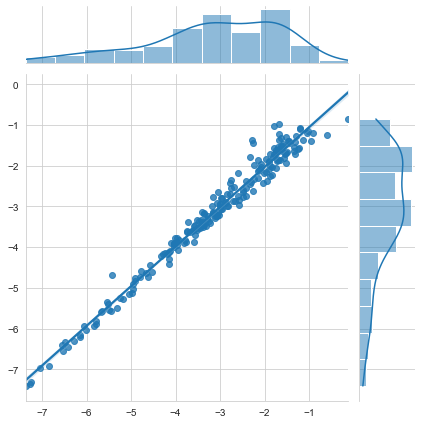

LinregressResult(slope=0.9750882154800643, intercept=-0.0788096884672278, rvalue=0.9886078126392621, pvalue=4.825757670139841e-173, stderr=0.01029357734637542, intercept_stderr=0.03622826390679035)

In [9]:
sns.jointplot(y=mj_matrix_triu_pred,x=mj_matrix[i_indices, j_indices], kind='reg')
plt.show()
scipy.stats.linregress(y=mj_matrix_triu_pred,x=mj_matrix[i_indices, j_indices])

> Notice that one can redefine the $q$'s in Eq. (2) by a shift and rescaling while leaving the interaction form unchanged. Therefore any transformation $q \rightarrow Aq + B$ with a corresponding change in the $C$'s yields an identical matrix.

To better understand the physical meaning of Eq. (2), rewrite it as:

$$
\begin{aligned}
\tilde{M}_{ij}&=h_{i} + h_{j} - \frac{C_{2}(q_{i}-q_{j})^{2}}{2}, \quad \text{Eq. }(3) \\
\text{where}\\
h_{i}&=\frac{C_{0}}{2}+C_{1}q_{i}+\frac{C_{2}}{2} q_{i}^{2}\\
\end{aligned}
$$

> Now each term in Eq. (3) above is invariant under the transformation discussed above.

In [10]:
h = C_0/2 + C_1 * q + C_2/2 * q**2

mj_matrix_triu_pred_from_h = h[i_indices] + h[j_indices] - C_2/2 * (q_is - q_js)**2
assert np.allclose(mj_matrix_triu_pred, mj_matrix_triu_pred_from_h)

> Comparison of the terms in Eq. (3) shows that the linear term $h_i + h_j$ is the dominant one in selecting the native structure.

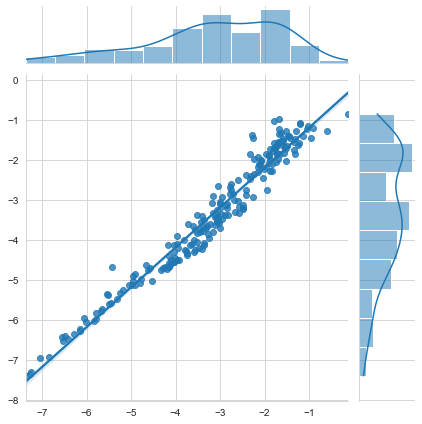

LinregressResult(slope=0.9980657756847827, intercept=-0.19685061953967686, rvalue=0.9793051326829264, pvalue=2.744235627334894e-146, stderr=0.014302012853078272, intercept_stderr=0.050335959851904546)

In [11]:
sns.jointplot(y=h[i_indices] + h[j_indices],
              x=mj_matrix[i_indices, j_indices], kind='reg')
plt.show()
scipy.stats.linregress(y=h[i_indices] + h[j_indices],
                       x=mj_matrix[i_indices, j_indices])


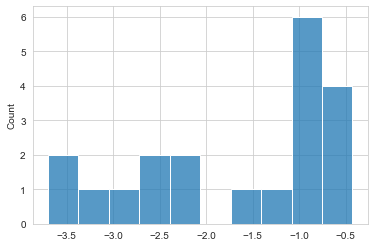

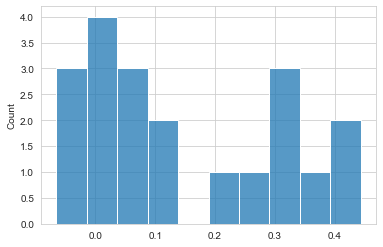

In [12]:
sns.histplot(h, bins=10)
plt.show()
sns.histplot(q, bins=10)
plt.show()

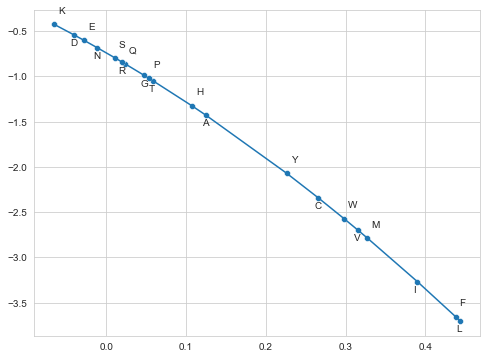

In [13]:
plt.figure(figsize=(8,6))
sns.lineplot(x=q, y=h)
ax = sns.scatterplot(x=q, y=h)
for idx_idx, idx in enumerate(np.argsort(q)):
    ax.text(q[idx]+0.005*(-1)**(idx_idx), h[idx]+0.12*(-1)**(idx_idx), mj_matrix_df.columns[idx])
plt.show()
